# 1.讀入套件


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

from tensorflow.keras import losses

from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

# 2.下載並整理資料

In [2]:
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

# 3.建立VAE模型

encoder和decoder各加一層、調整參數、並用relu作為激發函數

In [3]:
enc_1 = Dense(500, activation='relu')
enc_2 = Dense(250, activation='relu')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_3 = Dense(200, activation='relu')
dec_2 = Dense(400, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [4]:
x = Input(shape=(784,))
enc_x = enc_2(enc_1(x))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [6]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [7]:
# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(z_input)))

In [9]:
x_hat = dec_1(dec_2(dec_3(z)))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 500)          392500      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 250)          125250      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            502         dense_1[0][0]                    
____________________________________________________________________________________________

# 4.建立Loss函數

In [10]:
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

# 5.訓練VAE

In [11]:
VAE.compile(optimizer=Adam())

batch_size改為200，epochs改為5

In [13]:
VAE.fit(X_train,  
        batch_size=200, 
        epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 141us/sample - loss: 53.2051
Epoch 2/5
60000/60000 [==============================] - 7s 114us/sample - loss: 45.1225
Epoch 3/5
60000/60000 [==============================] - 7s 113us/sample - loss: 42.5914
Epoch 4/5
60000/60000 [==============================] - 7s 110us/sample - loss: 41.0044
Epoch 5/5
60000/60000 [==============================] - 6s 103us/sample - loss: 39.8971


# VAE視覺化

In [15]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 500)               392500    
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 502       
Total params: 518,252
Trainable params: 518,252
Non-trainable params: 0
_________________________________________________________________


In [16]:
VAE_Decoder = Model(z_input, dec_1(dec_2(dec_3(z_input))))

VAE_Decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               600       
_________________________________________________________________
dense_5 (Dense)              (None, 400)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               314384    
Total params: 395,384
Trainable params: 395,384
Non-trainable params: 0
_________________________________________________________________


# Encoder視覺化

In [17]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")

第 19955 圖的 latent 表示為 [ 2.5565062  -0.01248725]


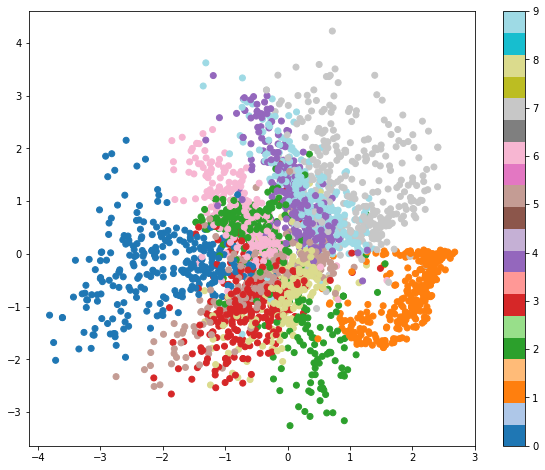

In [18]:
indices = np.random.randint(X_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(X_train[indices])

plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

# Decoder視覺化

In [19]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [20]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

In [21]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

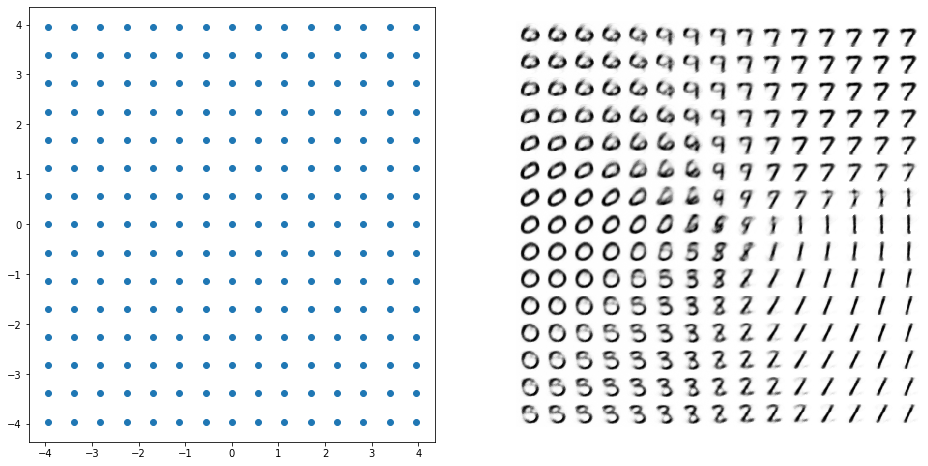

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

# 動態比較

In [24]:
idx_1, idx_2 = np.random.randint(X_train.shape[0], size=2)

In [25]:
def inBetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [27]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>